# Import Packages

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Import libraries for PDF and image processing
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

# Import libraries for text comparison and error measurement
from fuzzywuzzy import fuzz
from jiwer import wer, cer
from difflib import SequenceMatcher

# Import libraries for file handling and encoding
import os
import time  # Import time for latency measurement
import base64
from io import BytesIO
from PyPDF2 import PdfReader, PdfWriter
from typing import Union, Optional
from pathlib import Path

from anthropic import Anthropic

# Initialize global variables

In [5]:
API_KEY = '<API KEY>'
client = Anthropic(api_key=API_KEY)

In [125]:
PDF_SCRAPE_PROMPT = "Please extract all text from this image exactly as \
                    it appears, preserving all formatting and line breaks. \
                    Do not generate any preamble or descriptions."

pdf_path = 'bagel_jays.pdf'
max_tokens = 2048

## Extract with Claude pdf skill

In [79]:
def create_message_with_single_page(client, pdf_data, prompt, max_tokens):
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=max_tokens,
        messages=[{
            "role": "user",
            "content": [
                {
                    "type": "document",
                    "source": {
                        "type": "base64",
                        "media_type": "application/pdf",
                        "data": pdf_data
                    }
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }]
    )
    return message.content[0].text

In [ ]:
def process_pdf_pages(client, pdf_path, prompt, max_tokens, page_number=None):
    """
    Process PDF pages and extract text using Claude AI. This function can process a single page or all pages of a PDF.
    It measures the latency for each page request and stores the extracted text along with its latency in a txt file.

    Parameters:
    - client: The Claude AI client object.
    - pdf_path: The path to the PDF file.
    - prompt: The prompt to use for text extraction.
    - max_tokens: The maximum number of tokens to use for text extraction.
    - page_number: The specific page number to process. If None, all pages are processed.

    Returns:
    - A pandas DataFrame containing the page numbers and their corresponding latencies.
    """
    # Create a directory for ground truth data if it doesn't exist
    os.makedirs('ground_truth', exist_ok=True)

    pdf_reader = PdfReader(pdf_path)
    total_pages = len(pdf_reader.pages)

    if page_number is not None:
        if not 1 <= page_number <= total_pages:
            raise ValueError(f"Page number must be between 1 and {total_pages}")
        pages_to_process = [page_number - 1]  # Convert to 0-based index
    else:
        pages_to_process = range(total_pages)

    page_latencies = []
    for page_idx in pages_to_process:
        writer = PdfWriter()
        writer.add_page(pdf_reader.pages[page_idx])

        page_buffer = BytesIO()
        writer.write(page_buffer)
        page_buffer.seek(0)

        pdf_data = base64.b64encode(page_buffer.read()).decode()

        start_time = time.time()
        message_text = create_message_with_single_page(client, pdf_data, prompt, max_tokens)
        end_time = time.time()
        latency = end_time - start_time

        # Store the extracted text and its corresponding latency
        with open(f'ground_truth/claude_pg{page_idx + 1}.txt', 'w', encoding='utf-8') as f:
            f.write(message_text)
        page_latencies.append((page_idx + 1, latency))

    df_page_latencies = pd.DataFrame(page_latencies, columns=['Page Number', 'Latency'])
    return df_page_latencies


In [66]:
claude_page_latencies = process_pdf_pages(client, pdf_path, prompt=PDF_SCRAPE_PROMPT, max_tokens=max_tokens, page_number=None)

os.makedirs('results', exist_ok=True)
claude_page_latencies.to_csv('results/claude_latency.txt', index=False)

In [130]:
claude_page_latencies.describe()

,Page,Latency
count,46.000000,46.000000
mean,23.500000,23.189816
std,13.422618,9.931481
min,1.000000,5.189042
25%,12.250000,15.944308
50%,23.500000,24.286564
75%,34.750000,31.761492
max,46.000000,38.538824


## Extract with Tesseract 

In [3]:
def extract_text_tesseract_all_pages(pdf_path):
    """
    Extracts text from all pages of a PDF file using Tesseract OCR and measures the latency for each page.
    Saves the extracted text for each page in a separate file and returns a DataFrame with page numbers and their corresponding latencies.
    """
    os.makedirs('tesseract_output', exist_ok=True)
    page_latencies = []
    images = convert_from_path(pdf_path)
    for page_number, image in enumerate(images, start=1):
        if image:
            start_time = time.time()
            text = pytesseract.image_to_string(image)
            end_time = time.time()
            latency = end_time - start_time
            
            with open(f'tesseract_output/tesseract_pg{page_number}.txt', 'w', encoding='utf-8') as f:
                f.write(text)
            page_latencies.append((page_number, latency))
        else:
            print(f"Failed to convert PDF page {page_number} to image.")
    df_page_latencies = pd.DataFrame(page_latencies, columns=['Page Number', 'Latency'])
    return df_page_latencies

In [4]:
tesseract_page_latencies = extract_text_tesseract_all_pages(pdf_path)
tesseract_page_latencies.to_csv('results/tesseract_latency.txt', index=False)

In [132]:
tesseract_page_latencies.describe()

,Page Number,Latency
count,46.000000,46.000000
mean,23.500000,1.542758
std,13.422618,0.651107
min,1.000000,0.396972
25%,12.250000,1.074391
50%,23.500000,1.418920
75%,34.750000,2.159880
max,46.000000,2.432309


### Combine all outputs for Claude + Tesseract

In [43]:
total_pages = 46
dirs = {
    'ground_truth': ('claude_pg', 'claude_combined.txt'),
    'tesseract_output': ('tesseract_pg', 'tesseract_combined.txt')
}

for input_dir, (prefix, output_filename) in dirs.items():
    input_path = Path(input_dir)
    combined_content = []
    
    for page_num in range(1, total_pages + 1):
        input_file = input_path / f"{prefix}{page_num}.txt"
        
        try:
            with open(input_file, 'r', encoding='utf-8') as f:
                page_content = f.read().strip()
                combined_content.append(page_content)
        except FileNotFoundError:
            print(f"Missing file: {input_file}")
            
    output_file = input_path / output_filename
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(combined_content))

# Compare outputs: Claude vs. Tesseract

In [ ]:
from difflib import SequenceMatcher

def calculate_text_similarity(ground_truth, tesseract_output):
    # Create a SequenceMatcher object
    matcher = SequenceMatcher(None, ground_truth, tesseract_output)
    
    # Return similarity ratio
    return matcher.ratio()

In [135]:
from fuzzywuzzy import fuzz
from jiwer import wer, cer

def compute_and_print_metrics(ground_truth, tesseract_output):
    # Calculate Character Error Rate (CER)
    cer_score = cer(ground_truth, tesseract_output)
    
    # Calculate Word Error Rate (WER)
    wer_score = wer(ground_truth, tesseract_output)
    
    # Calculate Fuzz Partial Ratio
    fuzz_partial_ratio = fuzz.partial_ratio(ground_truth, tesseract_output)
    
    # Calculate Text Similarity using SequenceMatcher
    text_similarity = calculate_text_similarity(ground_truth, tesseract_output)
    
    return {
        "Character Error Rate (CER)": cer_score,
        "Word Error Rate (WER)": wer_score,
        "Fuzz Partial Ratio": fuzz_partial_ratio,
        "Text Similarity": text_similarity
    }

def run_for_all_pages(total_pages):
    print("Measures of Accuracy:")
    print("------------------------")
    print("1. Character Error Rate (CER): Measures the similarity between two strings based on the minimum number of single-character edits (insertions, deletions or substitutions) required to change one string into the other.")
    print("2. Word Error Rate (WER): Measures the similarity between two strings based on the minimum number of single-word edits (insertions, deletions or substitutions) required to change one string into the other.")
    print("3. Fuzz Partial Ratio: Measures the similarity between two strings based on the longest contiguous matching substring.")
    print("4. Text Similarity: Measures the similarity between two strings based on the longest contiguous matching subsequence, using the SequenceMatcher ratio method.")
    print("\n")

    results = []
    for page_number in range(1, total_pages + 1):
        ground_truth_path = f'ground_truth/claude_pg{page_number}.txt'
        with open(ground_truth_path, 'r', encoding='utf-8') as f:
            ground_truth = f.read()

        ocr_output_path = f'tesseract_output/tesseract_pg{page_number}.txt'
        with open(ocr_output_path, 'r', encoding='utf-8') as f:
            tesseract_output = f.read()

        metrics = compute_and_print_metrics(ground_truth, tesseract_output)
        metrics["Page Number"] = page_number
        results.append(metrics)

    df = pd.DataFrame(results)
    df.set_index('Page Number', inplace=True)
    return df

# Results

In [143]:
# Example usage
df = run_for_all_pages(46)
df

Measures of Accuracy:
------------------------
1. Character Error Rate (CER): Measures the similarity between two strings based on the minimum number of single-character edits (insertions, deletions or substitutions) required to change one string into the other.
2. Word Error Rate (WER): Measures the similarity between two strings based on the minimum number of single-word edits (insertions, deletions or substitutions) required to change one string into the other.
3. Fuzz Partial Ratio: Measures the similarity between two strings based on the longest contiguous matching substring.
4. Text Similarity: Measures the similarity between two strings based on the longest contiguous matching subsequence, using the SequenceMatcher ratio method.




,Character Error Rate (CER),Word Error Rate (WER),Fuzz Partial Ratio,Text Similarity
Page Number,,,,
1,0.202912,0.252492,91,0.865365
2,0.017518,0.061024,99,0.881519
3,0.020291,0.070312,95,0.951538
4,0.013970,0.114253,99,0.961255
5,0.004922,0.019488,100,0.977070
6,0.013387,0.131387,98,0.977252
7,0.002935,0.020802,91,0.886756
8,0.008164,0.042199,99,0.975794
9,0.004029,0.027500,100,0.985613


In [139]:
stats_rows = ['mean', 'std', 'min', 'max']
df.describe().loc[stats_rows]

,Character Error Rate (CER),Word Error Rate (WER),Fuzz Partial Ratio,Text Similarity
mean,0.103664,0.180956,84.217391,0.825734
std,0.211364,0.295402,24.620599,0.222434
min,0.000734,0.006112,13.000000,0.189349
max,0.980769,1.333333,100.000000,0.998413


array([[<Axes: title={'center': 'Character Error Rate (CER)'}>,
        <Axes: title={'center': 'Word Error Rate (WER)'}>],
       [<Axes: title={'center': 'Fuzz Partial Ratio'}>,
        <Axes: title={'center': 'Text Similarity'}>]], dtype=object)

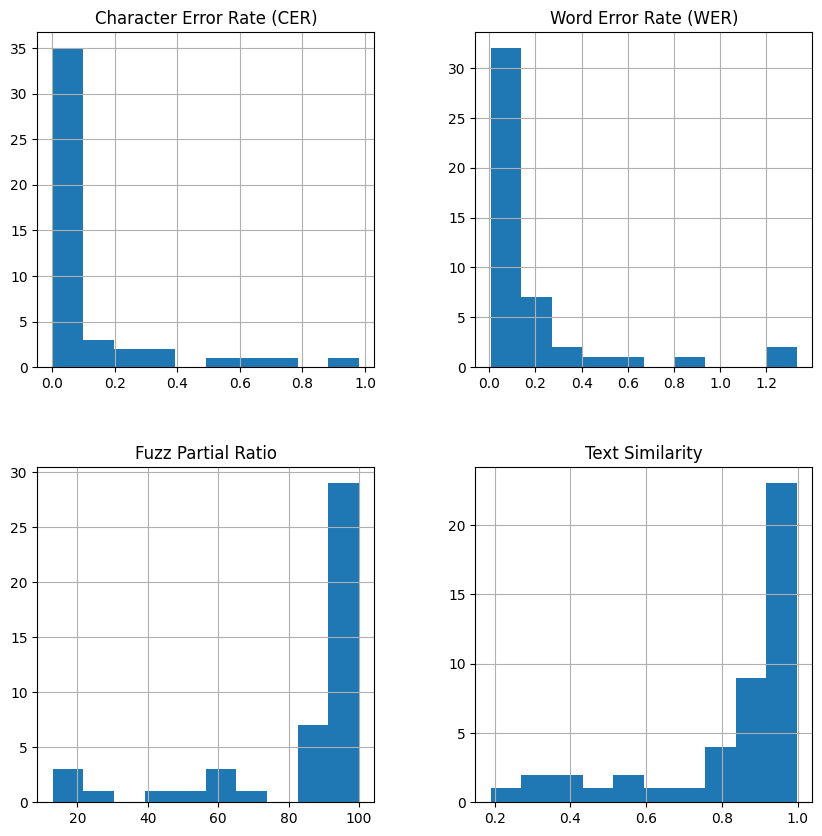

In [146]:
import matplotlib.pyplot as plt

df.hist(figsize=(10,10))
